Jeremy is interested in seeing the occupation at fixed mass as a func of concentration, and what, if any parameterization is a good fit. 

In [1]:
import numpy as np
from scipy.stats import binned_statistic
from pearce.mocks import compute_prim_haloprop_bins, cat_dict
from halotools.utils.table_utils import compute_conditional_percentiles

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
from itertools import cycle
sns.set_palette(sns.diverging_palette(255, 133, l=60, n=22, center="dark"))
colors = cycle(sns.color_palette())

In [3]:
PMASS = 591421440.0000001 #chinchilla 400/ 2048
#catalog = np.loadtxt('ab_sham_hod_data_cut.npy')

In [4]:
cosmo_params = {'simname':'chinchilla', 'Lbox':400.0, 'scale_factors':[0.658, 1.0]}
cat = cat_dict[cosmo_params['simname']](**cosmo_params)#construct the specified catalog!

cat.load_catalog(1.0)
#halo_masses = cat.halocat.halo_table['halo_mvir']

In [5]:
cen_hod = np.loadtxt('tabulated_cen_hod.npy')
sat_hod = np.loadtxt('tabulated_sat_hod.npy')
mbc = np.loadtxt('tabulated_mbc.npy')

In [6]:
from pearce.mocks.customHODModels import *

In [7]:
cat.load_model(1.0, HOD=(HSAssembiasTabulatedCens, HSAssembiasTabulatedSats), hod_kwargs = {'prim_haloprop_vals': mbc,
                                                               'sec_haloprop_key':'halo_vpeak',
                                                               'cen_hod_vals':cen_hod,
                                                               'sat_hod_vals':sat_hod,
                                                                'split': 0.5})

In [8]:
cat.model._haloprop_list

['halo_vpeak', 'halo_mvir']

In [9]:
#MAP = np.array([ 12.72747382,  14.24964974,   0.55068739,   0.18672767,
#    14.00597843,   1.06836772,  12.88931659, 1.0, -1.0, 2.0,  5 ])

MAP = np.array([ 12.72747382,  14.24964974,   0.55068739,   0.18672767,
    14.00597843,   1.06836772,  12.88931659, 1.0, -1.0, 5,  5 ])
       
names = ['logMmin', 'logMlin', 'sigma_logM', 'f_cen', 'logM1', 'alpha', 'logMcut',\
         'mean_occupation_centrals_assembias_param1','mean_occupation_satellites_assembias_param1',\
        'mean_occupation_centrals_assembias_slope1','mean_occupation_satellites_assembias_slope1']
params = dict(zip(names, MAP))

In [10]:
cat.populate(params)

In [11]:
len(cat.halocat.halo_table[np.logical_and(cat.halocat.halo_table['halo_mvir'] >=200*PMASS,\
                                          cat.halocat.halo_table['halo_upid']==-1)])

1628416

In [12]:
len(cat.model.mock.halo_table)

1628416

In [13]:
halo_table_clone = cat.halocat.halo_table[np.logical_and(cat.halocat.halo_table['halo_mvir'] >=200*PMASS,\
                                          cat.halocat.halo_table['halo_upid']==-1)]

In [14]:
cat.model.mock.halo_table.colnames, cat.halocat.halo_table.colnames

(['halo_upid',
  'halo_hostid',
  'halo_x',
  'halo_y',
  'halo_id',
  'halo_z',
  'halo_vx',
  'halo_vy',
  'halo_vz',
  'halo_rvir',
  'halo_vpeak',
  'halo_mvir',
  'conc_NFWmodel',
  'halo_num_centrals',
  'halo_num_satellites'],
 ['halo_upid',
  'halo_y',
  'halo_x',
  'halo_z',
  'halo_rvir',
  'halo_vpeak',
  'halo_rs_klypin',
  'halo_snapnum',
  'halo_halfmass_scale',
  'halo_id',
  'halo_vx',
  'halo_vy',
  'halo_vz',
  'halo_rs',
  'halo_mvir',
  'halo_nfw_conc',
  'halo_hostid',
  'halo_mvir_host_halo'])

In [15]:
mass_cut = cat.model.mock.halo_table['halo_mvir'] >=200*PMASS
 
masses =  cat.model.mock.halo_table['halo_mvir']
concentrations= halo_table_clone['halo_vpeak']#cat.model.mock.halo_table['halo_vpeak']#nfw_conc

catalog = np.zeros((np.sum(mass_cut), 6))
catalog[:,1] = cat.model.mock.halo_table['halo_num_centrals']
#catalog[:,1] = cat.model.model_dictionary['centrals_occupation'].mean_occupation(prim_haloprop=masses, sec_haloprop=concentrations)
catalog[:,2] = cat.model.mock.halo_table['halo_num_satellites']
#catalog[:,2] = cat.model.model_dictionary['satellites_occupation'].mean_occupation(prim_haloprop=masses, sec_haloprop=concentrations)
catalog[:,3] = masses
catalog[:,5] = concentrations

In [16]:
np.savetxt('hod_catalog.npy', catalog)

In [17]:
from math import ceil
def compute_mass_bins(prim_haloprop, dlog10_prim_haloprop=0.05):   
    lg10_min_prim_haloprop = np.log10(np.min(prim_haloprop))-0.001
    lg10_max_prim_haloprop = np.log10(np.max(prim_haloprop))+0.001
    num_prim_haloprop_bins = (lg10_max_prim_haloprop-lg10_min_prim_haloprop)/dlog10_prim_haloprop
    return np.logspace(
        lg10_min_prim_haloprop, lg10_max_prim_haloprop,
        num=int(ceil(num_prim_haloprop_bins)))

In [18]:
mass_bins = compute_mass_bins(catalog[:,3], 0.2)
mass_bin_centers = (mass_bins[1:]+mass_bins[:-1])/2.0
print mass_bins.shape

(22,)


In [19]:
halo_table = cat.halocat.halo_table[np.logical_and(cat.halocat.halo_table['halo_mvir'] >=200*PMASS,\
                                          cat.halocat.halo_table['halo_upid']==-1)]
nfw_conc= (halo_table['halo_rvir']/halo_table['halo_rs'])[halo_table['halo_upid']==-1]
klypin_conc = (halo_table['halo_rvir']/halo_table['halo_rs_klypin'])[halo_table['halo_upid']==-1]

In [20]:
mass_bin_idxs = compute_prim_haloprop_bins(prim_haloprop_bin_boundaries=mass_bins, prim_haloprop = catalog[:,3])

In [21]:
conc_bins = np.linspace(0,1000,10)#np.linspace(0,1000,10)#np.linspace(0, 22, 10)

In [22]:
params.keys()

['logMmin',
 'mean_occupation_centrals_assembias_param1',
 'logMlin',
 'sigma_logM',
 'mean_occupation_satellites_assembias_slope1',
 'f_cen',
 'mean_occupation_satellites_assembias_param1',
 'mean_occupation_centrals_assembias_slope1',
 'logM1',
 'alpha',
 'logMcut']

In [23]:
print max(mass_bin_idxs)

21


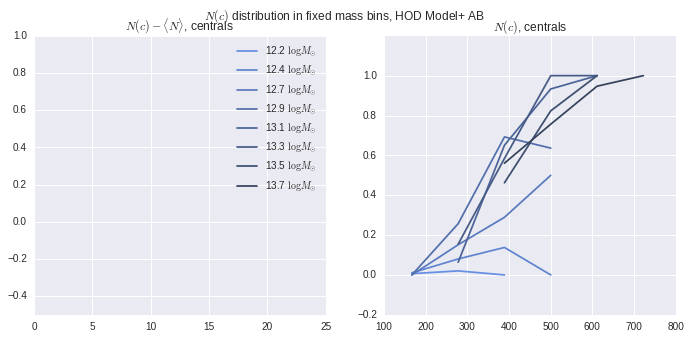

In [24]:
mass_bin_nos = range(5,13,1)
fig = plt.figure(figsize = ((11.5,5)))
for bin_no, c in zip(mass_bin_nos, colors):
    bin_center = np.mean(mass_bins[bin_no:bin_no+2])
    indices_of_mb = np.where(mass_bin_idxs == bin_no)[0]
    cens_avg, sats_avg = np.mean(catalog[indices_of_mb, 1]), np.mean(catalog[indices_of_mb, 2])

    med_conc = np.median(catalog[indices_of_mb, 5])
    
    (binned_cens, c_bins,_), (binned_sats,_,_) = binned_statistic(catalog[indices_of_mb,5], catalog[indices_of_mb, 1],bins=conc_bins), \
                               binned_statistic(catalog[indices_of_mb,5], catalog[indices_of_mb, 2], bins = conc_bins)
        
    cen_bin_counts, _, _ = binned_statistic(catalog[indices_of_mb,5],catalog[indices_of_mb,1], bins = conc_bins, statistic='sum')
    sat_bin_counts, _, _ = binned_statistic(catalog[indices_of_mb,5],catalog[indices_of_mb,2], bins = conc_bins, statistic='sum')
    #binned_sats[sat_bin_counts < len(indices_of_mb)/50] = sats_avg

    c_bin_centers = (c_bins[1:]+c_bins[:-1])/2
    plt.subplot(121)
    #plt.plot(c_bin_centers,(binned_sats-sats_avg), color = c,lw=2.5, label = r"%.1f $\log M_{\odot}$"%np.log10(bin_center) )
    #plt.errorbar(c_bin_centers,(binned_cens-cens_avg), yerr=np.sqrt(binned_cens/cen_bin_counts),color = c,label = r"%.1f $\log M_{\odot}$"%np.log10(bin_center))
    plt.plot(c_bin_centers,(binned_cens-cens_avg),color = c,label = r"%.1f $\log M_{\odot}$"%np.log10(bin_center))

    #plt.hist(catalog[indices_of_mb,5], bins = conc_bins, color = c, alpha = 0.3, normed=True)
    #plt.vlines(med_conc, -1, 1, color = c)
    
    plt.subplot(122)
    #plt.plot(c_bin_centers,binned_sats/sats_avg, color = c,lw=2.5)#, label = r"%.2f $M_{\odot}$"%bin_center)
    #plt.errorbar(c_bin_centers,(binned_cens/cens_avg), yerr=np.sqrt(binned_cens/(cens_avg*cen_bin_counts)),color = c)
    plt.plot(c_bin_centers,(binned_cens),color = c)

    #plt.vlines(med_conc, -1, 1, color = c)
    
    
plt.subplot(121)
#plt.xscale('log')
plt.title(r"$N(c)-\langle N \rangle$, centrals")
plt.legend(loc='best')
plt.xlim([0,25])
plt.ylim([-0.5,1.0])
plt.subplot(122)
plt.title(r"$N(c)$, centrals")
#plt.yscale('log')
#plt.xscale('log')
plt.ylim([-0.2,1.2])
#plt.xlim([0,25])
plt.suptitle(r"$N(c)$ distribution in fixed mass bins, HOD Model+ AB")
plt.show()

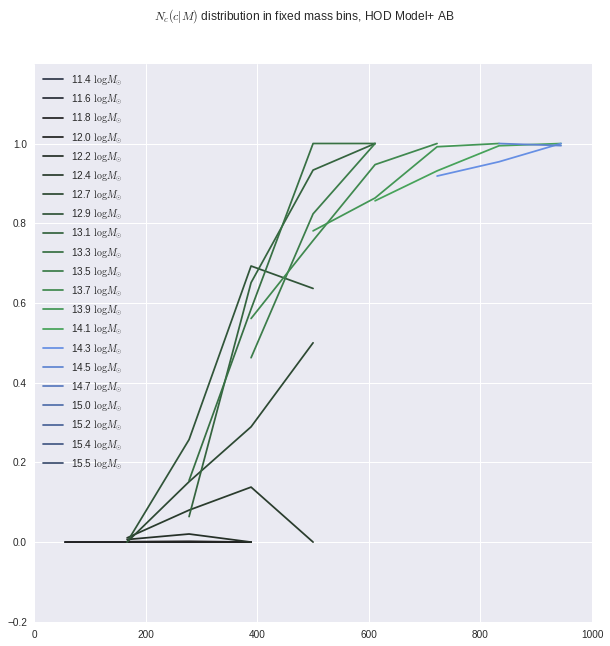

In [25]:
mass_bin_nos = range(1,22,1)
data = []
fig = plt.figure(figsize = ((10,10)))
for bin_no, c in zip(mass_bin_nos, colors):
    #if bin_no < 4 or bin_no >8:
    #    continue
    bin_center = np.mean(mass_bins[bin_no:bin_no+2])
    indices_of_mb = np.where(mass_bin_idxs == bin_no)[0]
    cens_avg, sats_avg = np.mean(catalog[indices_of_mb, 1]), np.mean(catalog[indices_of_mb, 2])

    med_conc = np.median(catalog[indices_of_mb, 5])

    (binned_cens, c_bins,_), (binned_sats,_,_) = binned_statistic(catalog[indices_of_mb,5], catalog[indices_of_mb, 1],bins=conc_bins), \
                               binned_statistic(catalog[indices_of_mb,5], catalog[indices_of_mb, 2], bins = conc_bins)
        
    cen_bin_counts, _, _ = binned_statistic(catalog[indices_of_mb,5],catalog[indices_of_mb,1], bins = conc_bins, statistic='sum')
    sat_bin_counts, _, _ = binned_statistic(catalog[indices_of_mb,5],catalog[indices_of_mb,2], bins = conc_bins, statistic='sum')
    #binned_sats[sat_bin_counts < len(indices_of_mb)/50] = sats_avg

    c_bin_centers = (c_bins[1:]+c_bins[:-1])/2
    #plt.subplot(121)
    #plt.plot(c_bin_centers,(binned_sats-sats_avg), color = c,lw=2.5, label = r"%.1f $\log M_{\odot}$"%np.log10(bin_center) )
    #plt.errorbar(c_bin_centers,(binned_cens-cens_avg), yerr=np.sqrt(binned_cens/cen_bin_counts),color = c,label = r"%.1f $\log M_{\odot}$"%np.log10(bin_center))
    #plt.plot(c_bin_centers,(binned_cens-cens_avg),color = c,label = r"%.1f $\log M_{\odot}$"%np.log10(bin_center))

    #plt.hist(catalog[indices_of_mb,5], bins = conc_bins, color = c, alpha = 0.3, normed=True)
    #plt.vlines(med_conc, -1, 1, color = c)
    
    #plt.subplot(122)
    #plt.plot(c_bin_centers,binned_sats/sats_avg, color = c,lw=2.5)#, label = r"%.2f $M_{\odot}$"%bin_center)
    #plt.errorbar(c_bin_centers,(binned_cens/cens_avg), yerr=np.sqrt(binned_cens/(cens_avg*cen_bin_counts)),color = c)
    plt.plot(c_bin_centers,(binned_cens),color = c,label = r"%.1f $\log M_{\odot}$"%np.log10(bin_center))
    data.append((c_bin_centers, binned_cens))
    #plt.vlines(med_conc, -1, 1, color = c)
    
    
#plt.subplot(121)
#plt.xscale('log')
#plt.title(r"$N(c)-\langle N \rangle$, centrals")
plt.legend(loc='best')
#plt.xlim([0,25])
#plt.ylim([-0.5,1.0])
#plt.subplot(122)
#plt.title(r"$N(c)$, centrals")
#plt.yscale('log')
#plt.xscale('log')
plt.ylim([-0.2,1.2])
plt.xlim([0,1000])
plt.suptitle(r"$N_c(c|M)$ distribution in fixed mass bins, HOD Model+ AB")
plt.show()

In [26]:
import cPickle as pickle
with open('cen_nc_occ.pkl', 'w') as f:
    pickle.dump(data,f )

In [27]:
occupation_ids = []
for bin_no in mass_bin_nos:
    bin_center = np.mean(mass_bins[bin_no:bin_no+2])
    indices_of_mb = np.where(mass_bin_idxs == bin_no)[0]
    cens_idxs = np.where(catalog[indices_of_mb,1] == 1)[0]
    occupation_ids.append(set(cat.model.mock.halo_table[mass_cut][cens_idxs]['halo_id']))

In [28]:
for o in occupation_ids:
    print len(o)

2
27
63
158
747
3029
6591
8588
8766
7436
5492
3894
2303
1449
777
385
170
59
24
4
2


In [29]:
import cPickle as pickle
with open('hod_cens_occ_id.pkl', 'w') as f:
    pickle.dump(occupation_ids, f)

In [30]:
print c_bin_centers
print c_bin_centers.shape

[  55.55555556  166.66666667  277.77777778  388.88888889  500.
  611.11111111  722.22222222  833.33333333  944.44444444]
(9,)


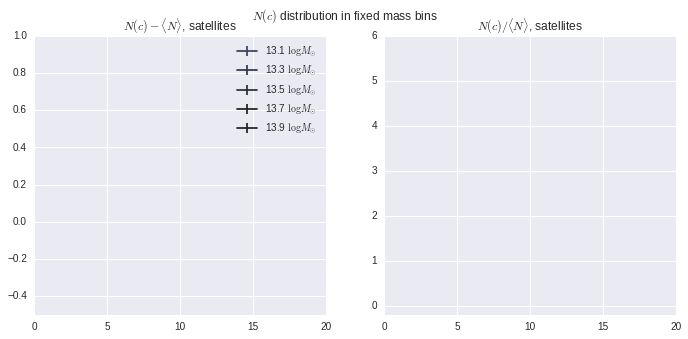

In [31]:
mass_bin_nos = range(9,14,1)
fig = plt.figure(figsize = ((11.5,5)))
for bin_no, c in zip(mass_bin_nos, colors):
    bin_center = np.mean(mass_bins[bin_no:bin_no+2])
    indices_of_mb = np.where(mass_bin_idxs == bin_no)[0]
    cens_avg, sats_avg = np.mean(catalog[indices_of_mb, 1]), np.mean(catalog[indices_of_mb, 2])
    
    med_conc = np.median(klypin_conc[indices_of_mb])

    (binned_cens, c_bins,_), (binned_sats,_,_) = binned_statistic(klypin_conc[indices_of_mb], catalog[indices_of_mb, 1],bins=conc_bins), \
                               binned_statistic(klypin_conc[indices_of_mb], catalog[indices_of_mb, 2], bins = conc_bins)
        
    sat_bin_counts, _, _ = binned_statistic(klypin_conc[indices_of_mb],catalog[indices_of_mb,2], bins = conc_bins, statistic='sum')
    #binned_sats[sat_bin_counts < len(indices_of_mb)/50] = sats_avg

    c_bin_centers = (c_bins[1:]+c_bins[:-1])/2
    plt.subplot(121)
    #plt.plot(c_bin_centers,(binned_sats-sats_avg), color = c,lw=2.5, label = r"%.1f $\log M_{\odot}$"%np.log10(bin_center) )
    plt.errorbar(c_bin_centers,(binned_sats-sats_avg), yerr=np.sqrt(binned_sats/sat_bin_counts),color = c,label = r"%.1f $\log M_{\odot}$"%np.log10(bin_center))
    #plt.hist(catalog[indices_of_mb,5], bins = conc_bins, color = c, alpha = 0.3, normed=True)
    #plt.vlines(med_conc, -1, 1, color = c)
    
    plt.subplot(122)
    #plt.plot(c_bin_centers,binned_sats/sats_avg, color = c,lw=2.5)#, label = r"%.2f $M_{\odot}$"%bin_center)
    plt.errorbar(c_bin_centers,(binned_sats/sats_avg), yerr=np.sqrt(binned_sats/(sats_avg*sat_bin_counts)),color = c)

    #plt.vlines(med_conc, -1, 1, color = c)
    
    
plt.subplot(121)
#plt.xscale('log')
plt.title(r"$N(c)-\langle N \rangle$, satellites")
plt.legend(loc='best')
plt.xlim([0,20])
plt.ylim([-0.5,1.0])
plt.subplot(122)
plt.title(r"$N(c)/\langle N \rangle$, satellites")
#plt.yscale('log')
#plt.xscale('log')
plt.ylim([-0.2,6])
plt.xlim([0,20])
plt.suptitle(r"$N(c)$ distribution in fixed mass bins")
plt.show()

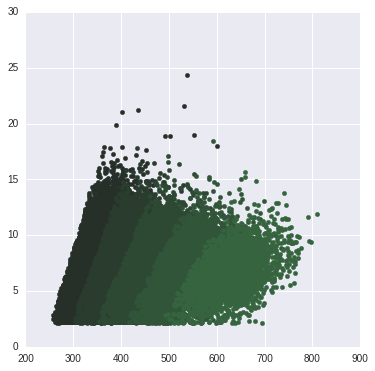

In [32]:
mass_bin_nos = range(9,14,1)
fig = plt.figure(figsize = ((6,6)))
for bin_no, c in zip(mass_bin_nos, colors):
    indices_of_mb = np.where(mass_bin_idxs == bin_no)[0]
    
    plt.scatter(catalog[indices_of_mb, 5], klypin_conc[indices_of_mb], color = c)
    
plt.show()

In [33]:
print len(catalog)
print len(klypin_conc)

1628416
1628416


In [34]:
colors2 = sns.color_palette()

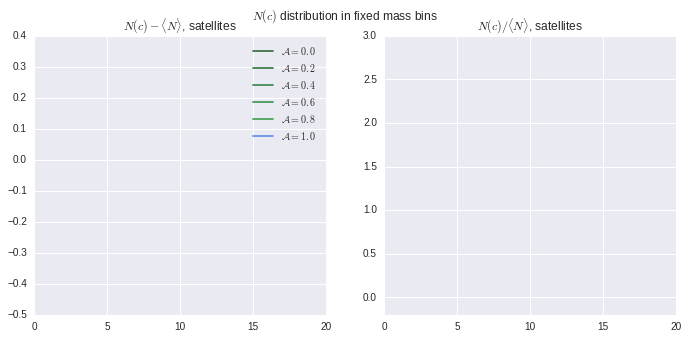

In [35]:
fig = plt.figure(figsize = ((11.5,5)))

for sat_ab, c  in zip(np.arange(0, 1.1, 0.2), colors):
    params['mean_occupation_satellites_assembias_param1'] = -1*sat_ab
    
    cat.populate(params)
    catalog[:,1] = cat.model.mock.halo_table['halo_num_centrals']
    catalog[:,2] = cat.model.mock.halo_table['halo_num_satellites']
    
    mass_bin_nos = range(9,14,1)
    bin_no = mass_bin_nos[-1]

    bin_center = np.mean(mass_bins[bin_no:bin_no+2])
    indices_of_mb = np.where(mass_bin_idxs == bin_no)[0]
    cens_avg, sats_avg = np.mean(catalog[indices_of_mb, 1]), np.mean(catalog[indices_of_mb, 2])

    med_conc = np.median(catalog[indices_of_mb, 5])

    (binned_cens, c_bins,_), (binned_sats,_,_) = binned_statistic(catalog[indices_of_mb,5], catalog[indices_of_mb, 1],bins=conc_bins), \
                               binned_statistic(catalog[indices_of_mb,5], catalog[indices_of_mb, 2], bins = conc_bins)

    sat_bin_counts, _, _ = binned_statistic(catalog[indices_of_mb,5],catalog[indices_of_mb,2], bins = conc_bins, statistic='sum')
    #binned_sats[sat_bin_counts < len(indices_of_mb)/50] = sats_avg

    c_bin_centers = (c_bins[1:]+c_bins[:-1])/2
    plt.subplot(121)
    #plt.plot(c_bin_centers,(binned_sats-sats_avg), color = c,lw=2.5, label = r"%.1f $\log M_{\odot}$"%np.log10(bin_center) )
    plt.plot(c_bin_centers,(binned_sats-sats_avg),color = c,label = r"$\mathcal{A}=%0.1f$"%sat_ab)
    #plt.hist(catalog[indices_of_mb,5], bins = conc_bins, color = c, alpha = 0.3, normed=True)
    #plt.vlines(med_conc, -1, 1, color = c)

    plt.subplot(122)
    #plt.plot(c_bin_centers,binned_sats/sats_avg, color = c,lw=2.5)#, label = r"%.2f $M_{\odot}$"%bin_center)
    plt.errorbar(c_bin_centers,(binned_sats/sats_avg), yerr=np.sqrt(binned_sats/(sats_avg*sat_bin_counts)),color = c)

    #plt.vlines(med_conc, -1, 1, color = c)


plt.subplot(121)
#plt.xscale('log')
plt.title(r"$N(c)-\langle N \rangle$, satellites")
plt.legend(loc='best')
plt.xlim([0,20])
plt.subplot(122)
plt.title(r"$N(c)/\langle N \rangle$, satellites")
#plt.yscale('log')
#plt.xscale('log')
plt.ylim([-0.2,3])
plt.xlim([0,20])
plt.suptitle(r"$N(c)$ distribution in fixed mass bins")
plt.show()

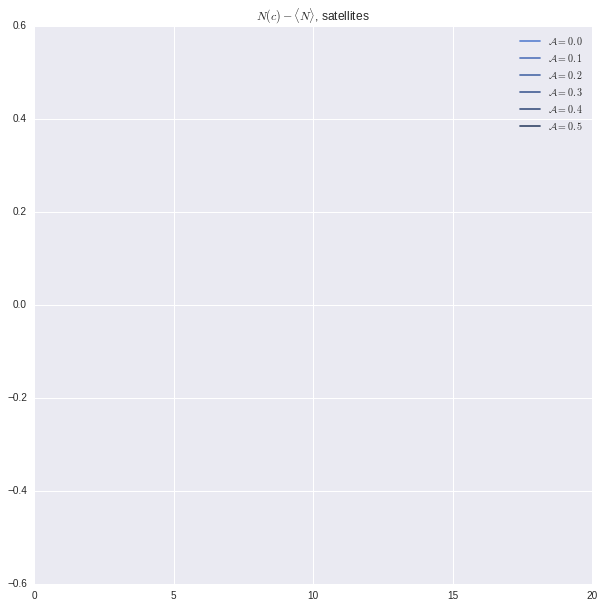

In [36]:
fig = plt.figure(figsize = ((10,10)))

for sat_ab, c  in zip(np.arange(0.0, 0.6, 0.1), colors):
    params['mean_occupation_satellites_assembias_param1'] = -1*sat_ab
    
    cat.populate(params)
    catalog[:,1] = cat.model.mock.halo_table['halo_num_centrals']
    catalog[:,2] = cat.model.mock.halo_table['halo_num_satellites']
    
    mass_bin_nos = range(9,14,1)
    bin_no = mass_bin_nos[-1]

    bin_center = np.mean(mass_bins[bin_no:bin_no+2])
    indices_of_mb = np.where(mass_bin_idxs == bin_no)[0]
    cens_avg, sats_avg = np.mean(catalog[indices_of_mb, 1]), np.mean(catalog[indices_of_mb, 2])

    med_conc = np.median(catalog[indices_of_mb, 5])

    (binned_cens, c_bins,_), (binned_sats,_,_) = binned_statistic(catalog[indices_of_mb,5], catalog[indices_of_mb, 1],bins=conc_bins), \
                               binned_statistic(catalog[indices_of_mb,5], catalog[indices_of_mb, 2], bins = conc_bins)

    sat_bin_counts, _, _ = binned_statistic(catalog[indices_of_mb,5],catalog[indices_of_mb,2], bins = conc_bins, statistic='sum')
    #binned_sats[sat_bin_counts < len(indices_of_mb)/50] = sats_avg

    c_bin_centers = (c_bins[1:]+c_bins[:-1])/2
    #plt.plot(c_bin_centers,(binned_sats-sats_avg), color = c,lw=2.5, label = r"%.1f $\log M_{\odot}$"%np.log10(bin_center) )
    plt.plot(c_bin_centers,(binned_sats-sats_avg),color = c,label = r"$\mathcal{A}=%0.1f$"%sat_ab)
    #plt.hist(catalog[indices_of_mb,5], bins = conc_bins, color = c, alpha = 0.3, normed=True)
    #plt.vlines(med_conc, -1, 1, color = c)
    
    catalog[:,1] = cat.model.model_dictionary['centrals_occupation'].mean_occupation(prim_haloprop=masses, sec_haloprop=concentrations)
    catalog[:,2] = cat.model.model_dictionary['satellites_occupation'].mean_occupation(prim_haloprop=masses, sec_haloprop=concentrations)
    
    (binned_cens, c_bins,_), (binned_sats,_,_) = binned_statistic(catalog[indices_of_mb,5], catalog[indices_of_mb, 1],bins=conc_bins), \
                               binned_statistic(catalog[indices_of_mb,5], catalog[indices_of_mb, 2], bins = conc_bins)

    sat_bin_counts, _, _ = binned_statistic(catalog[indices_of_mb,5],catalog[indices_of_mb,2], bins = conc_bins, statistic='sum')
    plt.plot(c_bin_centers,(binned_sats-sats_avg),color = c,ls = '--')



#plt.xscale('log')
plt.title(r"$N(c)-\langle N \rangle$, satellites")
plt.legend(loc='best')
plt.xlim([0,20])
plt.show()

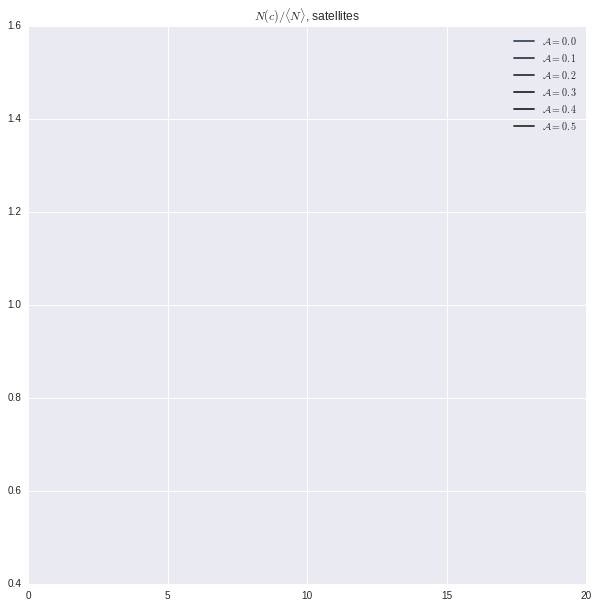

In [37]:
fig = plt.figure(figsize = ((10,10)))

for sat_ab, c  in zip(np.arange(0.0, 0.6, 0.1), colors):
    params['mean_occupation_satellites_assembias_param1'] = -1*sat_ab
    
    cat.populate(params)
    catalog[:,1] = cat.model.mock.halo_table['halo_num_centrals']
    catalog[:,2] = cat.model.mock.halo_table['halo_num_satellites']
    
    mass_bin_nos = range(9,14,1)
    bin_no = mass_bin_nos[-1]

    bin_center = np.mean(mass_bins[bin_no:bin_no+2])
    indices_of_mb = np.where(mass_bin_idxs == bin_no)[0]
    cens_avg, sats_avg = np.mean(catalog[indices_of_mb, 1]), np.mean(catalog[indices_of_mb, 2])

    med_conc = np.median(catalog[indices_of_mb, 5])

    (binned_cens, c_bins,_), (binned_sats,_,_) = binned_statistic(catalog[indices_of_mb,5], catalog[indices_of_mb, 1],bins=conc_bins), \
                               binned_statistic(catalog[indices_of_mb,5], catalog[indices_of_mb, 2], bins = conc_bins)

    sat_bin_counts, _, _ = binned_statistic(catalog[indices_of_mb,5],catalog[indices_of_mb,2], bins = conc_bins, statistic='sum')
    #binned_sats[sat_bin_counts < len(indices_of_mb)/50] = sats_avg

    c_bin_centers = (c_bins[1:]+c_bins[:-1])/2
    #plt.plot(c_bin_centers,(binned_sats-sats_avg), color = c,lw=2.5, label = r"%.1f $\log M_{\odot}$"%np.log10(bin_center) )
    plt.plot(c_bin_centers,(binned_sats/sats_avg),color = c,label = r"$\mathcal{A}=%0.1f$"%sat_ab)
    #plt.hist(catalog[indices_of_mb,5], bins = conc_bins, color = c, alpha = 0.3, normed=True)
    #plt.vlines(med_conc, -1, 1, color = c)
    
    catalog[:,1] = cat.model.model_dictionary['centrals_occupation'].mean_occupation(prim_haloprop=masses, sec_haloprop=concentrations)
    catalog[:,2] = cat.model.model_dictionary['satellites_occupation'].mean_occupation(prim_haloprop=masses, sec_haloprop=concentrations)
    
    (binned_cens, c_bins,_), (binned_sats,_,_) = binned_statistic(catalog[indices_of_mb,5], catalog[indices_of_mb, 1],bins=conc_bins), \
                               binned_statistic(catalog[indices_of_mb,5], catalog[indices_of_mb, 2], bins = conc_bins)

    sat_bin_counts, _, _ = binned_statistic(catalog[indices_of_mb,5],catalog[indices_of_mb,2], bins = conc_bins, statistic='sum')
    plt.plot(c_bin_centers,(binned_sats/sats_avg),color = c,ls = '--')



#plt.xscale('log')
plt.title(r"$N(c)/\langle N \rangle$, satellites")
plt.legend(loc='best')
plt.xlim([0,20])
plt.show()

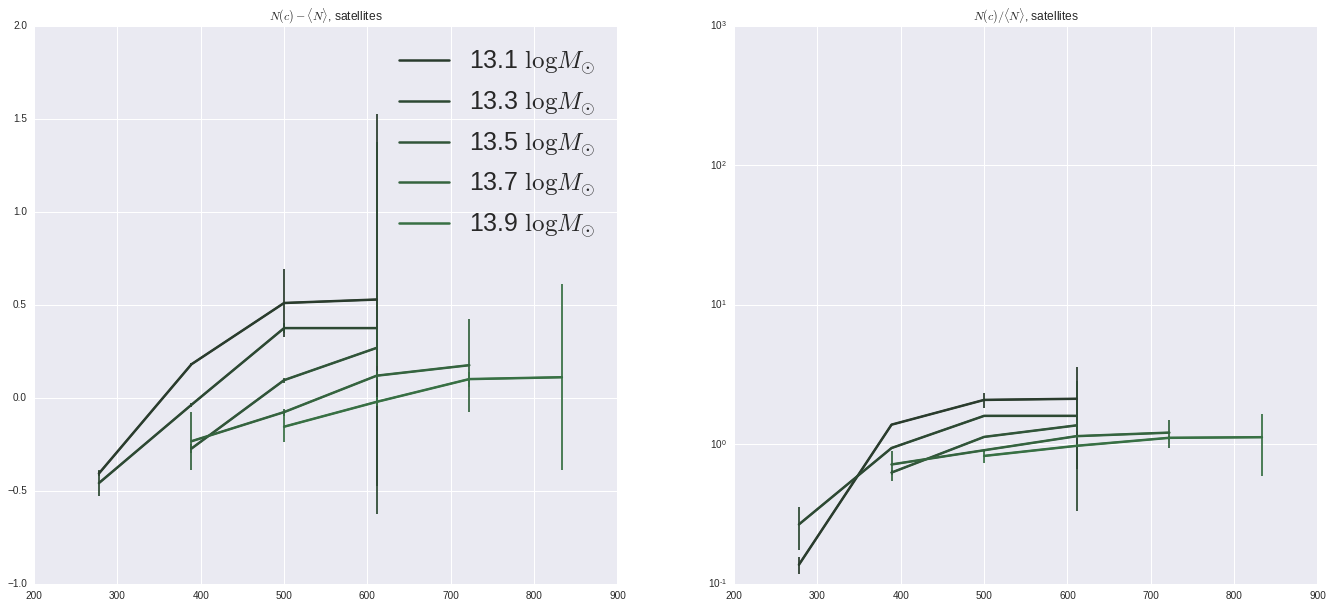

In [38]:
mass_bin_nos = range(9,14,1)
fig = plt.figure(figsize = ((23,10)))
for bin_no, c in zip(mass_bin_nos, colors):

    bin_center = np.mean(mass_bins[bin_no:bin_no+2])
    indices_of_mb = np.where(mass_bin_idxs == bin_no)[0]
    cens_avg, sats_avg = np.mean(catalog[indices_of_mb, 1]), np.mean(catalog[indices_of_mb, 2])

    med_conc = np.median(catalog[indices_of_mb, 5])

    (binned_cens, c_bins,_), (binned_sats,_,_) = binned_statistic(catalog[indices_of_mb,5], catalog[indices_of_mb, 1],bins=conc_bins), \
                               binned_statistic(catalog[indices_of_mb,5], catalog[indices_of_mb, 2], bins = conc_bins)
        
    cen_bin_counts, _, _ = binned_statistic(catalog[indices_of_mb,5],catalog[indices_of_mb,1], bins = conc_bins, statistic='sum')
    #binned_sats[sat_bin_counts < len(indices_of_mb)/20] = sats_avg

    c_bin_centers = (c_bins[1:]+c_bins[:-1])/2
    plt.subplot(121)
    plt.plot(c_bin_centers,(binned_cens-cens_avg), color = c,lw=2.5, label = r"%.1f $\log M_{\odot}$"%np.log10(bin_center) )
    plt.errorbar(c_bin_centers,(binned_cens-cens_avg), yerr=np.sqrt(binned_cens/cen_bin_counts),color = c)
    #plt.hist(catalog[indices_of_mb,5], bins = conc_bins, color = c, alpha = 0.3, normed=True)
    #plt.vlines(med_conc, -1, 1, color = c)
    
    plt.subplot(122)
    plt.plot(c_bin_centers,binned_cens/cens_avg, color = c,lw=2.5)#, label = r"%.2f $M_{\odot}$"%bin_center)
    plt.errorbar(c_bin_centers,(binned_cens/cens_avg), yerr=np.sqrt(binned_cens/(cens_avg*cen_bin_counts)),color = c)

    #plt.vlines(med_conc, -1, 1, color = c)
    
    
plt.subplot(121)
#plt.xscale('log')
plt.title(r"$N(c)-\langle N \rangle$, satellites")
plt.legend(loc='best', fontsize = 25)
plt.subplot(122)
plt.title(r"$N(c)/\langle N \rangle$, satellites")
plt.yscale('log')
#plt.xscale('log')
plt.ylim([1e-1,1e3])
plt.show()

Bin:  [  1.31408522e+12   2.12790035e+12]


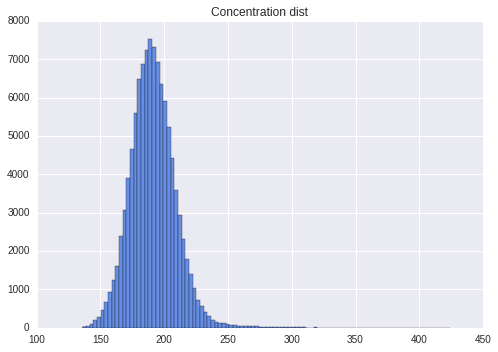

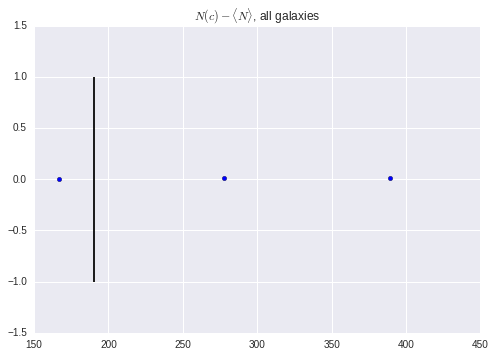

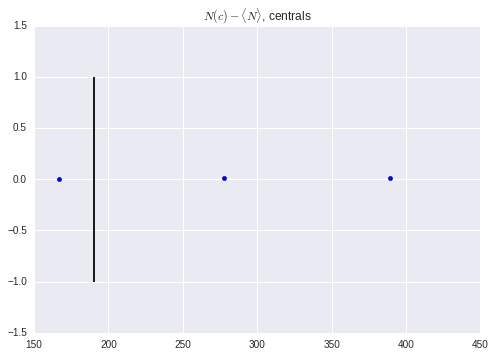

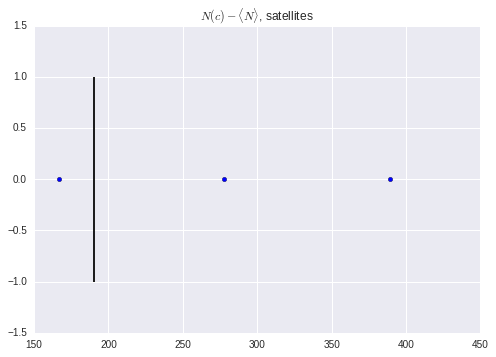

In [39]:
mass_bin_no = 5
print 'Bin: ', mass_bins[mass_bin_no:mass_bin_no+2]
indices_of_mb = np.where(mass_bin_idxs == mass_bin_no)[0]

plt.hist(catalog[indices_of_mb, 5], bins = 100);
plt.title('Concentration dist')
plt.show()

cens_avg, sats_avg = np.mean(catalog[indices_of_mb, 1]), np.mean(catalog[indices_of_mb, 2])

med_conc = np.median(catalog[indices_of_mb, 5])

(binned_cens, c_bins,_), (binned_sats,_,_) = binned_statistic(catalog[indices_of_mb,5], catalog[indices_of_mb, 1],bins=conc_bins), \
                           binned_statistic(catalog[indices_of_mb,5], catalog[indices_of_mb, 2], bins = conc_bins)
    
c_bin_centers = (c_bins[1:]+c_bins[:-1])/2

plt.scatter(c_bin_centers,binned_cens+ binned_sats-cens_avg-sats_avg)
plt.title(r"$N(c)-\langle N \rangle$, all galaxies")
plt.vlines(med_conc, -1, 1)
plt.show()

plt.scatter(c_bin_centers,binned_cens-cens_avg)
plt.title(r"$N(c)-\langle N \rangle$, centrals")
plt.vlines(med_conc, -1, 1)

plt.show()

plt.scatter(c_bin_centers,binned_sats-sats_avg)
plt.title(r"$N(c)-\langle N \rangle$, satellites")
plt.vlines(med_conc, -1, 1)

plt.show()

Bin:  [  9.03513313e+12   1.46306059e+13]


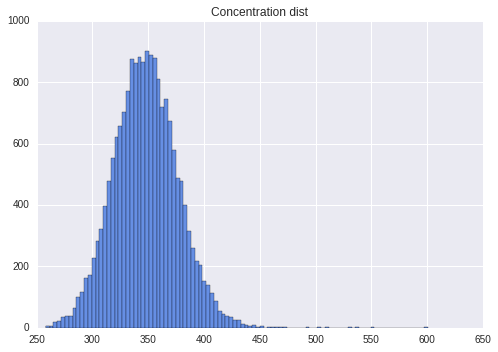

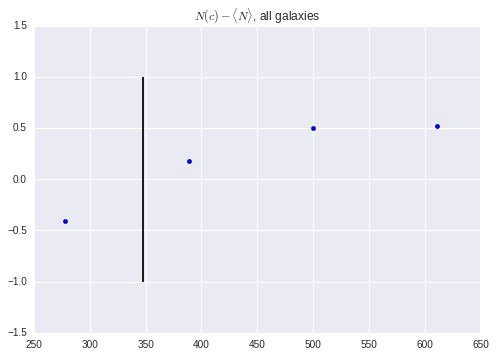

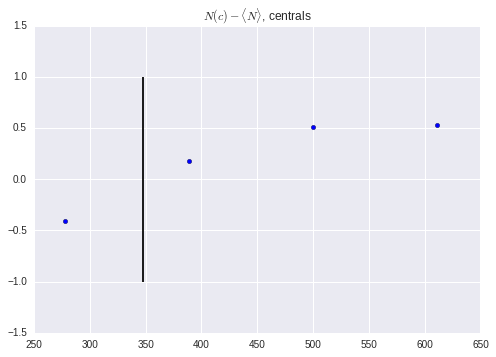

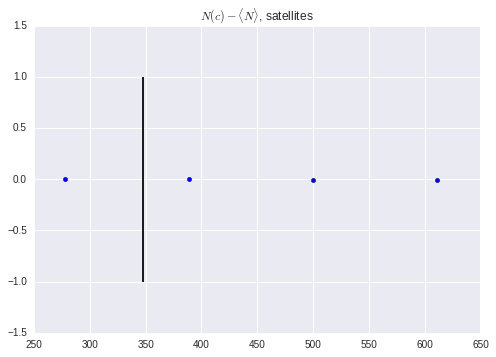

In [40]:
mass_bin_no = 9
print 'Bin: ', mass_bins[mass_bin_no:mass_bin_no+2]
indices_of_mb = np.where(mass_bin_idxs == mass_bin_no)[0]

plt.hist(catalog[indices_of_mb, 5], bins = 100);
plt.title('Concentration dist')
plt.show()

cens_avg, sats_avg = np.mean(catalog[indices_of_mb, 1]), np.mean(catalog[indices_of_mb, 2])

med_conc = np.median(catalog[indices_of_mb, 5])

(binned_cens, c_bins,_), (binned_sats,_,_) = binned_statistic(catalog[indices_of_mb,5], catalog[indices_of_mb, 1],bins=conc_bins), \
                           binned_statistic(catalog[indices_of_mb,5], catalog[indices_of_mb, 2], bins = conc_bins)
    
c_bin_centers = (c_bins[1:]+c_bins[:-1])/2

plt.scatter(c_bin_centers,binned_cens+binned_sats-cens_avg-sats_avg)
plt.title(r"$N(c)-\langle N \rangle$, all galaxies")
plt.vlines(med_conc, -1, 1)

plt.show()

plt.scatter(c_bin_centers,binned_cens-cens_avg)
plt.title(r"$N(c)-\langle N \rangle$, centrals")
plt.vlines(med_conc, -1, 1)

plt.show()

plt.scatter(c_bin_centers,binned_sats-sats_avg)
plt.title(r"$N(c)-\langle N \rangle$, satellites")
plt.vlines(med_conc, -1, 1)

plt.show()

Bin:  [  6.21220220e+13   1.00594292e+14]


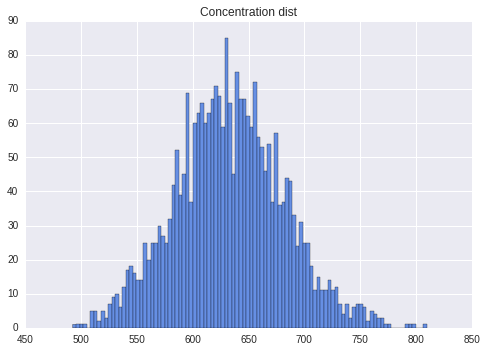

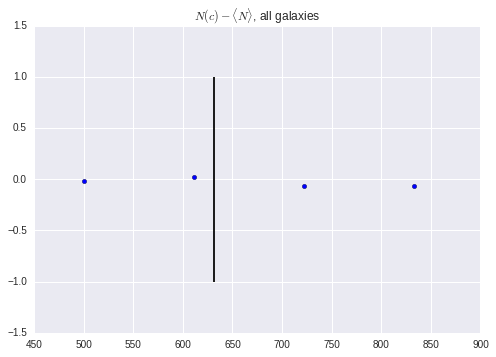

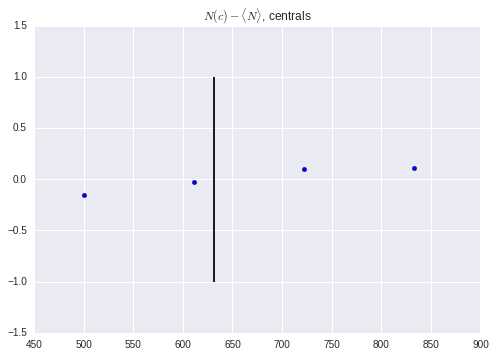

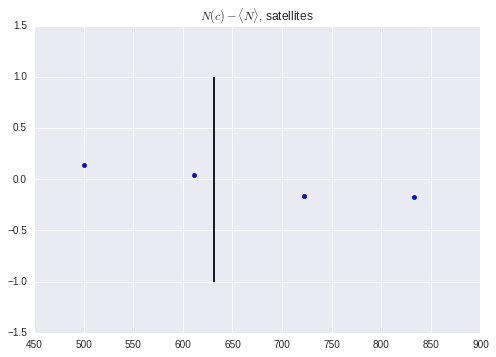

In [41]:
mass_bin_no = 13
print 'Bin: ', mass_bins[mass_bin_no:mass_bin_no+2]
indices_of_mb = np.where(mass_bin_idxs == mass_bin_no)[0]

plt.hist(catalog[indices_of_mb, 5], bins = 100);
plt.title('Concentration dist')
plt.show()

cens_avg, sats_avg = np.mean(catalog[indices_of_mb, 1]), np.mean(catalog[indices_of_mb, 2])

med_conc = np.median(catalog[indices_of_mb, 5])

(binned_cens, c_bins,_), (binned_sats,_,_) = binned_statistic(catalog[indices_of_mb,5], catalog[indices_of_mb, 1],bins=conc_bins), \
                           binned_statistic(catalog[indices_of_mb,5], catalog[indices_of_mb, 2], bins = conc_bins)
    
c_bin_centers = (c_bins[1:]+c_bins[:-1])/2

plt.scatter(c_bin_centers,binned_cens+binned_sats-cens_avg-sats_avg)
plt.title(r"$N(c)-\langle N \rangle$, all galaxies")
plt.vlines(med_conc, -1, 1)

plt.show()

plt.scatter(c_bin_centers,binned_cens-cens_avg)
plt.title(r"$N(c)-\langle N \rangle$, centrals")
plt.vlines(med_conc, -1, 1)

plt.show()

plt.scatter(c_bin_centers,binned_sats-sats_avg)
plt.title(r"$N(c)-\langle N \rangle$, satellites")
plt.vlines(med_conc, -1, 1)

plt.show()